In [1]:
#Author: Qian Wang
import os
import numpy as np
import pandas as pd
total_num_doc = 200

In [2]:
def get_filepaths(directory):
    
    file_paths = []  # List which will store all of the full filepaths.

    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)  # Add it to the list.

    return file_paths  # Self-explanatory.
  
def get_words(full_file_path, word_map):
    words = []
    
    for each in full_file_path:
        
        if (each.split("/")[-1][0] == "."):
            pass
        else:
           
            with open(each, 'r') as f:
                if f:
                    for eachline in f:
                        if eachline:
                            each = eachline.replace("(","").replace(")", "").replace("[", "").replace("]", "")
                            each = each.strip().split(',')
                            cluster_id = int(each[0])
                            words_index = np.array(map(int, each[1:]))
                            
                            words.append(list(word_map[words_index]))
            f.close()
    return words
            
if __name__ == "__main__":    
    word_map = np.loadtxt("corpus_big.txt", dtype = 'string', delimiter=" ")
    full_file_paths = get_filepaths("topwords_big")
    words = get_words(full_file_paths, word_map)
    with open("topwords.txt", 'w') as f:
        word = []
        for each in words:
            word += each
            f.write(str(each))
            f.write("\n")
    f.close()

    wordflag = map(lambda x: x[1:-1], set(word))

In [14]:
from sklearn.preprocessing import MinMaxScaler
df_data = pd.read_csv("data_feature_big.csv")
word_dict = {}
for each in wordflag:
    word_dict[each] = [0]*total_num_doc

with file("review_clean_big.txt", 'r') as f:
    for each in f:
        if each:
            each = each.strip().split()
            index = int(each[0])
            terms = each[1:]
            for eachword in terms:
                if eachword in wordflag: 
                    
                    (word_dict[eachword][index]) += 1
                    
for (key, value) in word_dict.items():
    df_data[key] = np.array(value).T 
df_data['claimed'] = df_data['is_claimed'].map(lambda x: 1 if x=="True" else 0)
df_data['location'] = df_data['city'].map(lambda x: 1 if x=="New York" else 0)
df_data['revcnt_norm'] = MinMaxScaler().fit_transform(df_data['review_count'] )

In [17]:
X_data = df_data.drop(['Unnamed: 0', 'index', 'city', 'review_count', 'is_claimed','name', 'url', 'rating'], axis = 1)
y_data = df_data['rating'].map(lambda x: 1 if x> 4 else 0)
print X_data.columns

Index([u'mexican', u'mikkey', u'asian', u'zeu', u'lassi', u'calamari',
       u'brunch', u'samosa', u'warren', u'rajun',
       ...
       u'burrito', u'gyro', u'dog', u'mango', u'egg', u'newli', u'wine',
       u'claimed', u'location', u'revcnt_norm'],
      dtype='object', length=135)


In [60]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from __future__ import division
from sklearn import metrics

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.grid_search import GridSearchCV

from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier


from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
mpl.rc('figure', figsize=[10,6]) # make the figures bigger


In [61]:
X_train, X_hold, y_train, y_hold = train_test_split(X_data, y_data, test_size=0.2, random_state = 42)

In [62]:
b = SelectKBest(chi2, k=40)
X_new = b.fit_transform(X_train, y_train)
print X_train.columns[b.get_support()]

Index([u'brunch', u'shanghai', u'pad', u'rice', u'vegan', u'game', u'ramen',
       u'cheesecak', u'dumpl', u'cafecito', u'fish', u'burger', u'lobster',
       u'poke', u'sum', u'smoothi', u'pasta', u'curri', u'owl', u'duck',
       u'beer', u'crab', u'lou', u'm2', u'frite', u'thai', u'donut', u'hyde',
       u'breakroom', u'deep', u'branko', u'bowl', u'torta', u'roll', u'pho',
       u'salsa', u'tuna', u'oyster', u'burrito', u'wine'],
      dtype='object')


Top 20 features:
1. revcnt_norm (0.062245)
2. wine (0.033852)
3. bowl (0.028086)
4. rice (0.025132)
5. fri (0.024507)
6. bread (0.023955)
7. sandwich (0.023331)
8. cocktail (0.018591)
9. soup (0.018181)
10. bar (0.018163)
11. duck (0.017708)
12. fish (0.017645)
13. roll (0.017526)
14. frite (0.016667)
15. egg (0.015671)
16. avocado (0.015607)
17. brunch (0.015459)
18. burger (0.015331)
19. chicago (0.014805)
20. italian (0.014758)


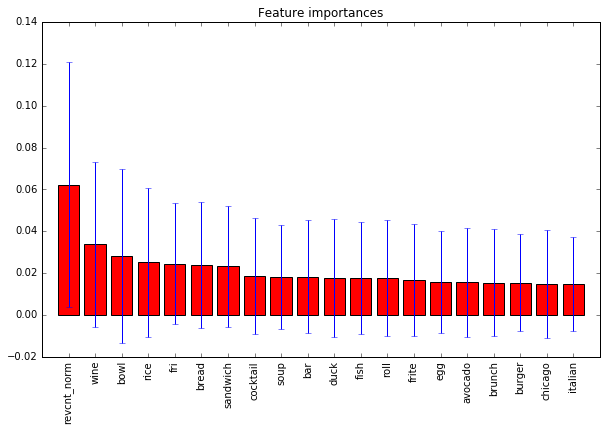

In [35]:
def vrank(X, y):       
        forest = RandomForestClassifier(n_estimators=250, random_state=0)
        forest.fit(X, y)
        importances = forest.feature_importances_
        std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
        indices = np.argsort(importances)[::-1]
        # Print the feature ranking
        print  "Top 20 features:"
        for f in range(20):
            print("%d. %s (%f)" % (f + 1, X.columns[indices[f]],importances[indices[f]]))
        # Plot the feature importances of the forest
        plt.figure()
        plt.title("Feature importances")
        plt.bar(range(20), importances[indices[:20]], color="r", yerr=std[indices[:20]], align="center")
        plt.xticks(range(20), X.columns[indices[:20]], rotation='vertical')
        plt.xlim([-1, 20])
        plt.show()
        return X.columns[indices]
rankfeatures = vrank(X_train, y_train)    

In [63]:
#classification model using random forest
class_weight = [{1:i} for i in range(1, 11)]

rf = GridSearchCV(RandomForestClassifier(), param_grid={'max_depth': range(10, 101, 10), 'n_estimators': range(10, 51, 10), 'class_weight': class_weight}, cv = 5, scoring='f1_weighted')
rf.fit(X_train, y_train)
print "Best parameters set found on development set:"
print
print(rf.best_params_)
print(rf.best_score_)

rf_predict = rf.predict(X_hold)
print f1_score(y_hold, rf_predict)


Best parameters set found on development set:

{'n_estimators': 10, 'max_depth': 100, 'class_weight': {1: 5}}
0.656589246847
0.25


In [69]:
#classification model using ExtraTrees
class_weight = [{1:i} for i in range(1, 11)]

et = GridSearchCV(ExtraTreesClassifier(), param_grid={'max_depth': range(10, 101, 10), 'n_estimators': range(10, 51, 10), 'class_weight': class_weight}, cv = 5, scoring='f1_weighted')
et.fit(X_train, y_train)
print "Best parameters set found on development set:"
print
print(et.best_params_)
print(et.best_score_)

et_predict = et.predict(X_hold)
print f1_score(y_hold, et_predict)


Best parameters set found on development set:

{'n_estimators': 10, 'max_depth': 90, 'class_weight': {1: 3}}
0.658722527473
0.181818181818


In [65]:
#classification model using Logistic Regression
X_train_new = X_train[rankfeatures[:30]]
X_hold_new = X_hold[rankfeatures[:30]]
class_weight = [{1:i} for i in range(1, 11)]
lr = GridSearchCV(LogisticRegression(), param_grid={'C':[0.01, 0.1, 1, 10, 100], 'class_weight': class_weight}, cv = 5, scoring='f1_weighted')
lr.fit(X_train_new, y_train)
print "Best parameters set found on development set:"
print
print(lr.best_params_)
print(lr.best_score_)

lr_predict = lr.predict(X_hold_new)
print f1_score(y_hold, lr_predict)

Best parameters set found on development set:

{'C': 0.1, 'class_weight': {1: 2}}
0.64885280708
0.173913043478


In [66]:
#classification model using SGD
class_weight = [{1:i} for i in range(1, 11)]
sgd = GridSearchCV(SGDClassifier(), param_grid={'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': class_weight}, cv = 5, scoring='f1_weighted')
sgd.fit(X_train_new, y_train)
print "Best parameters set found on development set:"
print
print(sgd.best_params_)
print(sgd.best_score_)

sgd_predict = sgd.predict(X_hold_new)
print f1_score(y_hold, sgd_predict)

Best parameters set found on development set:

{'alpha': 1, 'class_weight': {1: 1}}
0.678932258695
0.181818181818


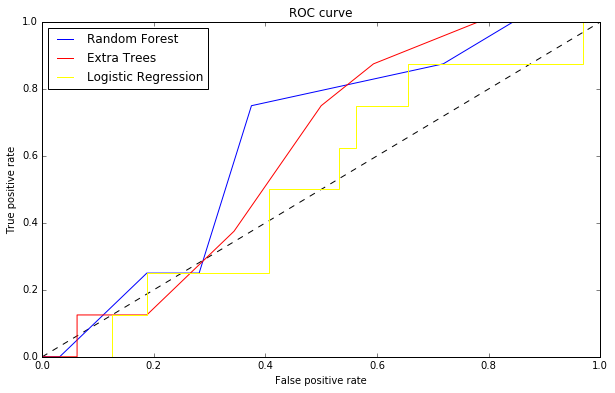

In [75]:
rf_score = rf.predict_proba(X_hold)[:, 1]
et_score = et.predict_proba(X_hold)[:, 1]
lr_score = lr.predict_proba(X_hold_new)[:, 1]


fpr1, tpr1, thresholds1 = roc_curve(np.array(y_hold), rf_score)
fpr2, tpr2, thresholds2 = roc_curve(np.array(y_hold), et_score)
fpr3, tpr3, thresholds3 = roc_curve(np.array(y_hold), lr_score)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr1, tpr1, color = 'blue', label = "Random Forest")
plt.plot(fpr2, tpr2, color = 'red', label = "Extra Trees")
plt.plot(fpr3, tpr3, color = 'yellow', label = "Logistic Regression")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()